In [1]:
import mmcv
import os.path as osp
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette
from mmcv import Config
from marsemseg.datasets import PALETTE, CLASSES
from marsemseg.datasets.mastr1325 import MaSTr1325
from mmseg.apis import set_random_seed
import pickle
import json
import matplotlib.pyplot as plt

/home/sebastiangarcia/anaconda3/envs/marmemseg/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cfg = Config.fromfile("../configs/models/pspnet_r50-d8_512x1024_40k_cityscapes.py")

In [3]:
with open("../data/processed/mastr1325/img_norm_cfg.json", "r") as f:
    img_norm_cfg = json.load(f)

img_norm_cfg

{'mean': [162.6392278223229, 172.14175911717751, 150.29345586635898],
 'std': [51.71795318544171, 51.44594804983497, 48.12313234515298],
 'to_rgb': True}

In [4]:
data_root = "../data/processed/mastr1325"
img_dir = "images"
ann_dir = "annotations"

In [5]:
# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = len(CLASSES)
cfg.model.auxiliary_head.num_classes = len(CLASSES)

# Modify dataset type and path
cfg.dataset_type = 'MaSTr1325'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 8

cfg.img_norm_cfg = img_norm_cfg
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(512, 384), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(384, 512),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = '../models/pretrained/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '../models/finetuned/pspnet2'

cfg.runner.max_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200
cfg.model.backbone.pretrained = None

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = "cuda"

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True,
        pretrained=None),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=4,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=

In [6]:
cfg.dump("../configs/models/finetuend_pspnet_r50-d8_512x1024_40k_cityscapes.py")

In [6]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]


2022-07-09 00:17:53,543 - mmseg - INFO - Loaded 1192 images


In [7]:
# Build the detector
model = build_segmentor(cfg.model)

/home/sebastiangarcia/anaconda3/envs/marmemseg/lib/python3.8/site-packages/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/sebastiangarcia/anaconda3/envs/marmemseg/lib/python3.8/site-packages/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


In [8]:
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-07-09 00:18:06,793 - mmseg - INFO - Loaded 133 images
2022-07-09 00:18:06,795 - mmseg - INFO - load checkpoint from local path: ../models/pretrained/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
2022-07-09 00:18:07,033 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([4, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([4]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([4, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([4]).
2022-07-09 00:1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 133/133, 16.1 task/s, elapsed: 8s, ETA:     0s

2022-07-09 00:19:59,405 - mmseg - INFO - per class results:
2022-07-09 00:19:59,406 - mmseg - INFO - 
+----------+-------+-------+
|  Class   |  IoU  |  Acc  |
+----------+-------+-------+
| obstacle | 86.93 | 92.76 |
|  water   | 97.69 | 98.62 |
|   sky    | 98.75 |  99.6 |
| unknown  |  nan  |  nan  |
+----------+-------+-------+
2022-07-09 00:19:59,406 - mmseg - INFO - Summary:
2022-07-09 00:19:59,406 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 98.5 | 94.46 | 96.99 |
+------+-------+-------+
2022-07-09 00:19:59,407 - mmseg - INFO - Iter(val) [133]	aAcc: 0.9850, mIoU: 0.9446, mAcc: 0.9699, IoU.obstacle: 0.8693, IoU.water: 0.9769, IoU.sky: 0.9875, IoU.unknown: nan, Acc.obstacle: 0.9276, Acc.water: 0.9862, Acc.sky: 0.9960, Acc.unknown: nan


In [9]:
!cat ../data/raw/mastr1325/splits/val.txt | head -n 10

cat: ../data/raw/mastr1325/splits/val.txt: No such file or directory


/home/sebastiangarcia/anaconda3/envs/marmemseg/lib/python3.8/site-packages/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 432x288 with 0 Axes>

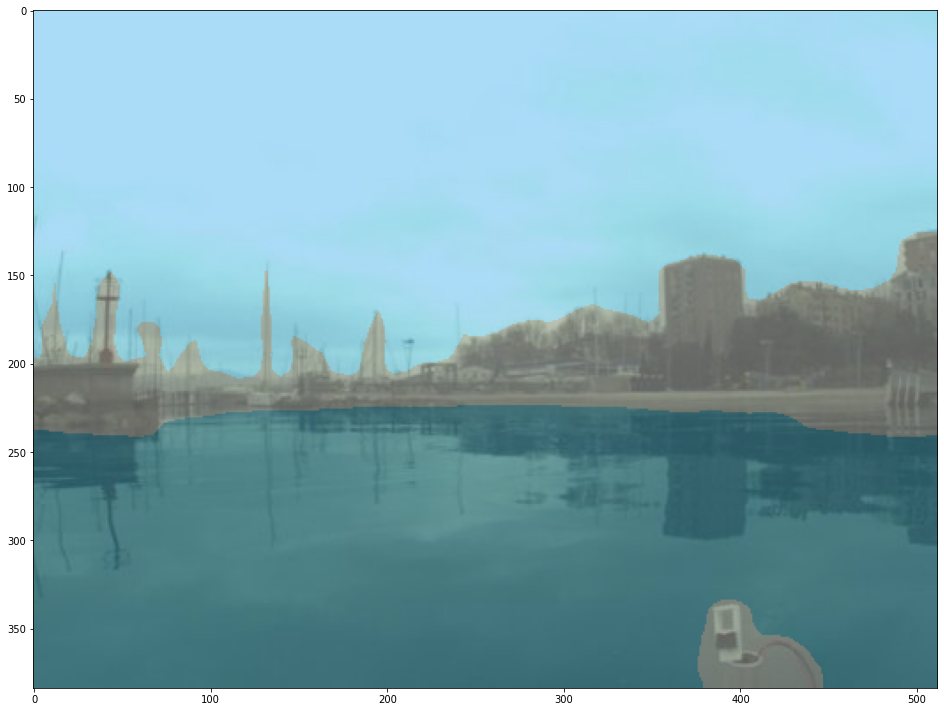

In [11]:
img = mmcv.imread("../data/processed/mastr1325/images/0357.jpg")
model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(6, 4))
show_result_pyplot(model, img, result, PALETTE)

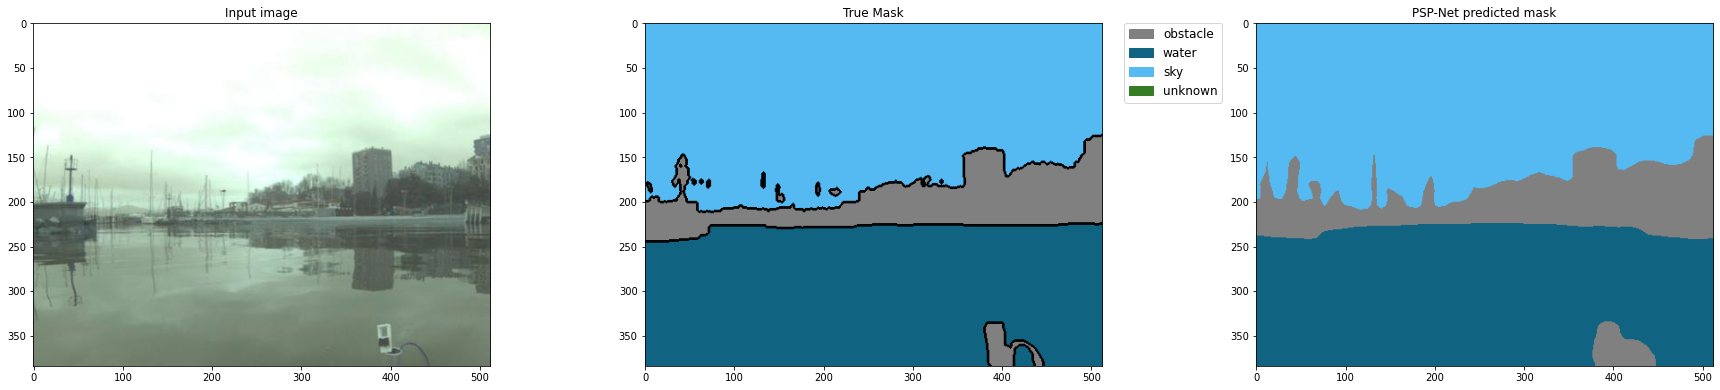

In [12]:
from PIL import Image
import numpy as np
import matplotlib.patches as mpatches

true_mask = mmcv.imread("../data/processed/mastr1325/masks/0357m.png")[..., 0]
true_mask = Image.fromarray(true_mask).convert("P")
true_mask.putpalette(np.array(PALETTE).astype(np.uint8))

pred_mask = Image.fromarray(result[0].astype(np.uint8)).convert("P")
pred_mask.putpalette(np.array(PALETTE).astype(np.uint8))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8*3, 16))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(
    color=np.array(PALETTE[i])/255., 
    label=CLASSES[i]) 
    for i in range(4)
]

ax[1].legend(
    handles=patches, 
    bbox_to_anchor=(1.05, 1), 
    loc=2, 
    borderaxespad=0., 
    fontsize='large'
)

ax[0].imshow(img)
ax[0].set_title("Input image")

ax[1].imshow(true_mask)
ax[1].set_title("True Mask")

ax[2].imshow(pred_mask)
ax[2].set_title("PSP-Net predicted mask")

plt.tight_layout()
plt.show()